In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import time
import gc
import missingno as msno

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [2]:
#df_train = pd.read_csv('porto-seguro-safe-driver-prediction/train.csv')
#df_test = pd.read_csv('porto-seguro-safe-driver-prediction/test.csv')

df_train = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/test.csv')

In [3]:
print('Training data shape: {}'.format(df_train.shape))
print('Training data shape: {}'.format(df_test.shape))

Training data shape: (595212, 59)
Training data shape: (892816, 58)


In [4]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: False
Is null on test: False


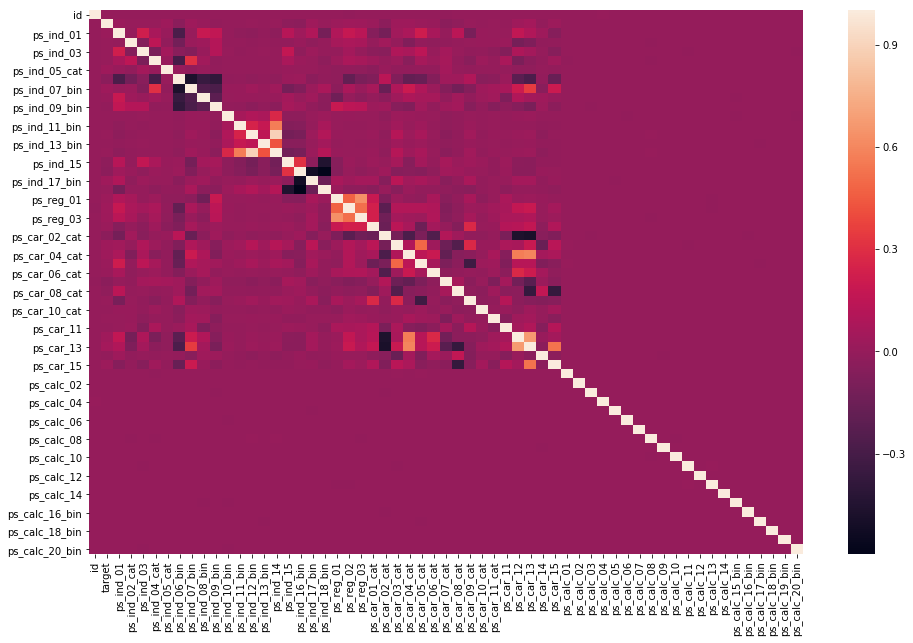

In [5]:
import seaborn as sns
cor = df_train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

In [6]:
col_to_drop = list(df_train.columns[df_train.columns.str.startswith('ps_calc_')])
df_train = df_train.drop(col_to_drop, axis=1)  
df_test = df_test.drop(col_to_drop, axis=1)

In [7]:
def get_missing_features(df):
    missings = pd.DataFrame([], columns=['feature', 'no_recoreds', 'percentage'])
    total_rows = df.shape[0]
    index = 0
    for feature in list(df):
        total_nulls = df[feature].isnull().sum()
        if total_nulls > 0:
            missings_perc = total_nulls / total_rows
            missings.loc[index] = [feature, total_nulls, missings_perc]
            index += 1
    missings = missings.sort_values('no_recoreds', ascending=False)
    return missings

In [8]:
df_missings = get_missing_features(df_train)
print(df_missings)

Empty DataFrame
Columns: [feature, no_recoreds, percentage]
Index: []


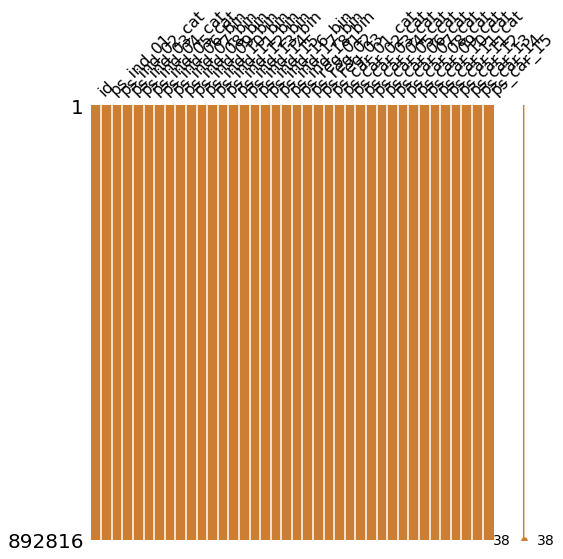

In [9]:
msno.matrix(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

In [10]:
vars_with_missing = []

for feature in df_train.columns:
    missings = df_train[df_train[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/df_train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


In [11]:
cat_cols = [col for col in df_train.columns if '_cat' in col]
dummed_cols = []

for cat_col in cat_cols:
    unique_values = len(np.unique(df_train[cat_col]))
    if unique_values < 50:
        dummed_cols.append(cat_col)
    print('{} has {} unique values'.format(cat_col, unique_values))

ps_ind_02_cat has 5 unique values
ps_ind_04_cat has 3 unique values
ps_ind_05_cat has 8 unique values
ps_car_01_cat has 13 unique values
ps_car_02_cat has 3 unique values
ps_car_03_cat has 3 unique values
ps_car_04_cat has 10 unique values
ps_car_05_cat has 3 unique values
ps_car_06_cat has 18 unique values
ps_car_07_cat has 3 unique values
ps_car_08_cat has 2 unique values
ps_car_09_cat has 6 unique values
ps_car_10_cat has 3 unique values
ps_car_11_cat has 104 unique values


In [12]:
dummed_cols

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat']

In [13]:

desired_apriori=0.10

# Get the indices per target value
idx_0 = df_train[df_train.target == 0].index
idx_1 = df_train[df_train.target == 1].index

# Get original number of records per target value
nb_0 = len(df_train.loc[idx_0])
nb_1 = len(df_train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
df_train = df_train.loc[idx_list].reset_index(drop=True)


Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [14]:
df_train = df_train.replace(-1, np.nan)
df_test = df_test.replace(-1, np.nan)

In [15]:
id_test = df_test['id'].values
y = df_train['target'].values

df_train = df_train.drop(['target','id'], axis = 1)
df_test = df_test.drop(['id'], axis = 1)

cat_features = [a for a in df_train.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_train[column]))
    df_train = pd.concat([df_train,temp],axis=1)
    df_train = df_train.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_test[column]))
    df_test = pd.concat([df_test,temp],axis=1)
    df_test = df_test.drop([column],axis=1)

print(df_train.values.shape, df_test.values.shape)

(216940, 198) (892816, 198)


In [16]:
# from https://www.kaggle.com/mashavasilenko/
# porto-seguro-xgb-modeling-and-parameters-tuning
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [17]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))
        #folds = list(KFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))
        
        '''
                                  private score        public score
        stratified k-fold         0.29171(15th)           0.28439 
        k-fold                    0.29142(24th)           0.28447
        
        k-fold cross validation은 데이터를 k개의 data fold로 분할하고 각 iteration마다 test set을 다르게 할당하여 
        train fold와 test fold를 구성한다.
        모델을 학습하는데 k번의 iteration이 필요하고 각각의 data fold set에서 나온 검증결과들의 평균으로 최종 검증 결과를 도출
        
        Stratified k-fikd는 data fold set을 구성하는 함수에서 데이터 label의 분포까지 고려하므로
        각 fold안의 데이터셋의 label 분포가 전체 데이터셋의 label분포를 따른다.
        k-fold보다 각 fold가 전체 데이터셋을 잘 대표하여 모델을 학습시킬 때 편향되지 않게 학습시킬 수 있다.
        label의 분포가 불균형한 데이터셋에서 적합한 방법이다.
        '''

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                
                clf.fit(X_train, y_train)
                valid_pred = clf.predict_proba(X_valid)[:,1]
                S_train[valid_idx, i] = valid_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            
            print( "\nTraining Gini for model {} : {}".format(i, eval_gini(y, S_train[:,i])))
            S_test[:, i] = S_test_i.mean(axis=1)
            
        return S_train, S_test

In [18]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 700 # 생성할 트리의 갯수
lgb_params['max_bin'] = 15
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 800
lgb_params['random_state'] = 99
lgb_params['scale_pos_weight'] = 3 # 샘플 스케일링, 불균형셋에서 유용

lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02
lgb_params2['n_estimators'] = 900
lgb_params2['max_bin'] = 20
lgb_params2['subsample'] = 0.8
lgb_params2['subsample_freq'] = 10
lgb_params2['colsample_bytree'] = 0.8   
lgb_params2['min_child_samples'] = 600
lgb_params2['random_state'] = 99
lgb_params2['scale_pos_weight'] = 3
#lgb_params2['device'] = 'gpu'

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4
#lgb_params3['device'] = 'gpu'

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic' # 각 단계에서 계산할 최적화 목표를 정의, defalut는 reg:linear
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9 # 각각의 트리를 만들 때 데이터에서 사용할 열의 비율(0~1) 
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

cat_params = {}
cat_params['learning_rate'] = 0.04
cat_params['depth'] = 6
cat_params['iterations'] = 650
cat_params['loss_function'] = 'Logloss'

lgb_model = LGBMClassifier(**lgb_params)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)
cat_model = CatBoostClassifier(**cat_params)

In [19]:
lgb_stack = Create_ensemble(n_splits = 5, base_models = [cat_model, lgb_model, lgb_model2, lgb_model3, xgb_model])        
X = df_train
Y = y
T = df_test
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X, Y, T)

0:	learn: 0.6586465	total: 117ms	remaining: 1m 15s
1:	learn: 0.6270886	total: 175ms	remaining: 56.8s
2:	learn: 0.5986813	total: 235ms	remaining: 50.6s
3:	learn: 0.5729128	total: 292ms	remaining: 47.2s
4:	learn: 0.5495107	total: 350ms	remaining: 45.2s
5:	learn: 0.5282841	total: 407ms	remaining: 43.7s
6:	learn: 0.5091401	total: 464ms	remaining: 42.6s
7:	learn: 0.4915643	total: 521ms	remaining: 41.8s
8:	learn: 0.4759537	total: 578ms	remaining: 41.1s
9:	learn: 0.4614689	total: 623ms	remaining: 39.9s
10:	learn: 0.4485237	total: 680ms	remaining: 39.5s
11:	learn: 0.4367593	total: 737ms	remaining: 39.2s
12:	learn: 0.4261557	total: 795ms	remaining: 39s
13:	learn: 0.4165508	total: 855ms	remaining: 38.8s
14:	learn: 0.4076654	total: 914ms	remaining: 38.7s
15:	learn: 0.3996607	total: 974ms	remaining: 38.6s
16:	learn: 0.3924266	total: 1.03s	remaining: 38.4s
17:	learn: 0.3858102	total: 1.09s	remaining: 38.3s
18:	learn: 0.3798644	total: 1.14s	remaining: 38s
19:	learn: 0.3745668	total: 1.2s	remaining: 

In [20]:
# Create submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = lgb_test_pred.mean(axis=1)
#sub.to_csv('lightgbm_submit_ensemble_features.csv', float_format='%.6f', index=False)

sub.to_csv('/kaggle/working/submission.csv', float_format='%.6f', index=False)


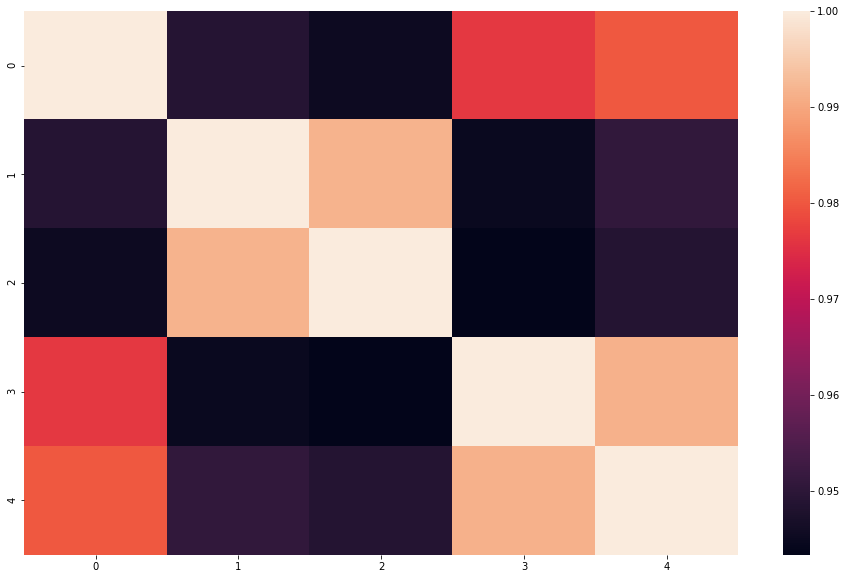

In [21]:
import seaborn as sns
test_pred_df = pd.DataFrame(data = lgb_test_pred)
cor = test_pred_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)